Env :  projetday1


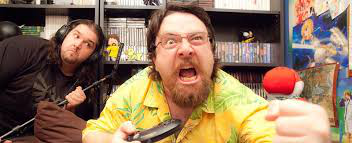

In [1]:

import os
import numpy as np
from PIL import Image
from ISR.models import RDN

print ("Env : ", os.environ['CONDA_DEFAULT_ENV'])

datapath = '/media/xav/data/pday1/'
img = Image.open(datapath+'sample/téléchargement.jpeg')
lr_img = np.array(img.convert("RGB"))
Image.fromarray(lr_img)


(143, 352, 3)


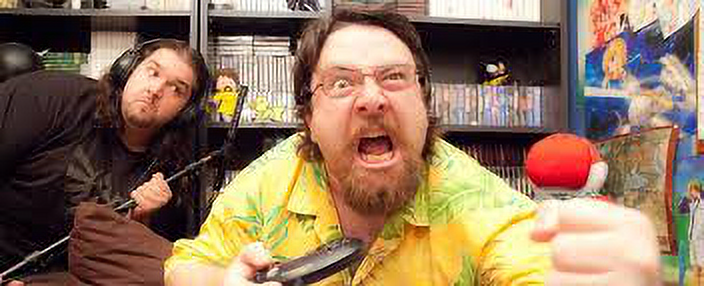

In [2]:

import numpy as np
from PIL import Image

#img = Image.open('/home/xav/Images/Capture d’écran de 2020-08-17 19-21-21.png' )

img = Image.open(datapath+'sample/téléchargement.jpeg')
lr_img = np.array(img.convert("RGB"))
print(lr_img.shape)
#Image.fromarray(lr_img)
#img = Image.open(datapath+'sample/sam.png' )

#lr_img = np.array(img)
#print(lr_img.shape)

from ISR.models import RDN

#rrdn.model.load_weights('/media/xav/data/telechargement/rrdn-C4-D3-G32-G032-T10-x4_epoch299.hdf5' )
#print(np.concatenate((lr_img,)*2, axis=-1).shape)
#Image.fromarray(np.concatenate((lr_img,)*3, axis=-1))

#rdn = RDN(weights='psnr-small')

rdn = RDN(arch_params={'C':3, 'D':10, 'G':64, 'G0':64, 'x':2})
rdn.model.load_weights(datapath+'weights/rdn-C3-D10-G64-G064-x2_PSNR_epoch134.hdf5')


sr_img = rdn.predict(lr_img,  by_patch_of_size=50)

#sr_img = rdn.predict(lr_img)
Image.fromarray(sr_img)

#sr_img = model.predict(image, by_patch_of_size=50)





In [3]:
from ISR.models import RDN
from ISR.models import Discriminator
from ISR.models import Cut_VGG19

lr_train_patch_size = 40
layers_to_extract = [5, 9]
scale = 4
hr_train_patch_size = lr_train_patch_size * scale

rrdn  = RDN(arch_params={'C':4, 'D':3, 'G':64, 'G0':64, 'T':10, 'x':scale}, patch_size=lr_train_patch_size)
f_ext = Cut_VGG19(patch_size=hr_train_patch_size, layers_to_extract=layers_to_extract)
discr = Discriminator(patch_size=hr_train_patch_size, kernel_size=3)

In [4]:
from ISR.train import Trainer

loss_weights = {
  'generator': 0.0,
  'feature_extractor': 0.0833,
  'discriminator': 0.01
}
losses = {
  'generator': 'mae',
  'feature_extractor': 'mse',
  'discriminator': 'binary_crossentropy'
}

log_dirs = {'logs': datapath+'/logs', 'weights': datapath+'/weights'}

learning_rate = {'initial_value': 0.0004, 'decay_factor': 0.5, 'decay_frequency': 30}

flatness = {'min': 0.0, 'max': 0.15, 'increase': 0.01, 'increase_frequency': 5}

adam_optimizer = {'beta1': 0.9, 'beta2': 0.999, 'epsilon': None}

trainer = Trainer(
    generator=rrdn,
    discriminator=discr,
    feature_extractor=f_ext,
    lr_train_dir=datapath+'div2k/DIV2K_train_LR_bicubic/X4/',
    hr_train_dir=datapath+'div2k/DIV2K_train_HR/',
    lr_valid_dir=datapath+'div2k/DIV2K_valid_LR_bicubic/X4/',
    hr_valid_dir=datapath+'div2k/DIV2K_valid_HR/',
    loss_weights=loss_weights,
    losses=losses,
    learning_rate=learning_rate,
    flatness=flatness,
    log_dirs=log_dirs,
    adam_optimizer=adam_optimizer,
    metrics={'generator': 'PSNR_Y'},
    dataname='div2k',
    weights_generator=None,
    weights_discriminator=None,
    n_validation=40,
)


In [5]:
trainer.train(
    epochs=60,
    steps_per_epoch=200,
    batch_size=4,
    monitored_metrics={'val_generator_loss': 'min'}
)



Training details:
  training_parameters: 
    lr_train_dir: /media/xav/data/pday1/div2k/DIV2K_train_LR_bicubic/X4/
    hr_train_dir: /media/xav/data/pday1/div2k/DIV2K_train_HR/
    lr_valid_dir: /media/xav/data/pday1/div2k/DIV2K_valid_LR_bicubic/X4/
    hr_valid_dir: /media/xav/data/pday1/div2k/DIV2K_valid_HR/
    loss_weights: {'generator': 0.0, 'feature_extractor': 0.0833, 'discriminator': 0.01}
    log_dirs: {'logs': '/media/xav/data/pday1//logs', 'weights': '/media/xav/data/pday1//weights'}
    fallback_save_every_n_epochs: 2
    dataname: div2k
    n_validation: 40
    flatness: {'min': 0.0, 'max': 0.15, 'increase': 0.01, 'increase_frequency': 5}
    learning_rate: {'initial_value': 0.0004, 'decay_factor': 0.5, 'decay_frequency': 30}
    adam_optimizer: {'beta1': 0.9, 'beta2': 0.999, 'epsilon': None}
    losses: {'generator': 'mae', 'feature_extractor': 'mse', 'discriminator': 'binary_crossentropy'}
    metrics: {'generator': <function PSNR_Y at 0x7f1d40237320>}
    lr_patch_size

160/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

{'val_loss': 0.4021555268205702, 'val_generator_loss': 0.07879681, 'val_discriminator_loss': 0.788721, 'val_feature_extractor_loss': 1.8975722, 'val_feature_extractor_1_loss': 7.568653, 'val_generator_PSNR_Y': 22.230057, 'train_d_real_loss': 0.030979149, 'train_d_real_accuracy': 1.0, 'train_d_fake_loss': 0.112818755, 'train_d_fake_accuracy': 0.9951562, 'train_loss': 0.6061035, 'train_generator_loss': 0.08810476, 'train_discriminator_loss': 0.84473586, 'train_feature_extractor_loss': 2.9629107, 'train_feature_extractor_1_loss': 11.386576, 'train_generator_PSNR_Y': 21.061184}
val_generator_loss improved from        inf to    0.07880
Saving weights
Epoch 1/60
Current learning rate: 0.00039999998989515007
100%|██████████| 200/200 [01:35<00:00,  2.10it/s]
Epoch 1 took       95.4s


160/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

{'val_loss': 0.33843836477026346, 'val_generator_loss': 0.06947522, 'val_discriminator_loss': 1.1926281, 'val_feature_extractor_loss': 1.6848043, 'val_feature_extractor_1_loss': 6.154622, 'val_generator_PSNR_Y': 23.39431, 'train_d_real_loss': 0.048341442, 'train_d_real_accuracy': 1.0, 'train_d_fake_loss': 0.012765544, 'train_d_fake_accuracy': 1.0, 'train_loss': 0.28719535, 'train_generator_loss': 0.0634014, 'train_discriminator_loss': 1.2076793, 'train_feature_extractor_loss': 1.5744709, 'train_feature_extractor_1_loss': 5.0310163, 'train_generator_PSNR_Y': 23.581472}
val_generator_loss improved from    0.07880 to    0.06948
Saving weights
Epoch 2/60
Current learning rate: 0.00039999998989515007
100%|██████████| 200/200 [01:31<00:00,  2.19it/s]
Epoch 2 took       91.2s


160/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

{'val_loss': 0.31497202860191464, 'val_generator_loss': 0.06732062, 'val_discriminator_loss': 0.6095933, 'val_feature_extractor_loss': 1.6078951, 'val_feature_extractor_1_loss': 5.808098, 'val_generator_PSNR_Y': 23.509596, 'train_d_real_loss': 0.009174739, 'train_d_real_accuracy': 1.0, 'train_d_fake_loss': 0.0047472296, 'train_d_fake_accuracy': 1.0, 'train_loss': 0.13051553, 'train_generator_loss': 0.07691503, 'train_discriminator_loss': 0.68308836, 'train_feature_extractor_loss': 0.5539312, 'train_feature_extractor_1_loss': 2.415688, 'train_generator_PSNR_Y': 21.999474}
val_generator_loss improved from    0.06948 to    0.06732
Saving weights
Epoch 3/60
Current learning rate: 0.00039999998989515007
100%|██████████| 200/200 [01:30<00:00,  2.21it/s]
Epoch 3 took       90.6s


160/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

{'val_loss': 0.3104253875091672, 'val_generator_loss': 0.055181127, 'val_discriminator_loss': 0.6227993, 'val_feature_extractor_loss': 1.6251185, 'val_feature_extractor_1_loss': 5.6785398, 'val_generator_PSNR_Y': 25.145214, 'train_d_real_loss': 0.004374291, 'train_d_real_accuracy': 1.0, 'train_d_fake_loss': 0.0014258724, 'train_d_fake_accuracy': 1.0, 'train_loss': 0.07227758, 'train_generator_loss': 0.02896923, 'train_discriminator_loss': 0.52925926, 'train_feature_extractor_loss': 0.2891662, 'train_feature_extractor_1_loss': 1.3191168, 'train_generator_PSNR_Y': 29.868938}
val_generator_loss improved from    0.06732 to    0.05518
Saving weights
Epoch 4/60
Current learning rate: 0.00039999998989515007
100%|██████████| 200/200 [01:28<00:00,  2.26it/s]
Epoch 4 took       88.5s


160/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

{'val_loss': 0.30239277901127937, 'val_generator_loss': 0.056131136, 'val_discriminator_loss': 0.550791, 'val_feature_extractor_loss': 1.6032197, 'val_feature_extractor_1_loss': 5.5248675, 'val_generator_PSNR_Y': 25.183542, 'train_d_real_loss': 0.0017321568, 'train_d_real_accuracy': 1.0, 'train_d_fake_loss': 0.001273043, 'train_d_fake_accuracy': 1.0, 'train_loss': 0.050351594, 'train_generator_loss': 0.05596236, 'train_discriminator_loss': 0.50030637, 'train_feature_extractor_loss': 0.20858854, 'train_feature_extractor_1_loss': 0.88021165, 'train_generator_PSNR_Y': 26.05939}
val_generator_loss did not improve.
Epoch 5/60
Current learning rate: 0.00039999998989515007
Current flatness treshold: 0.01
100%|██████████| 200/200 [01:27<00:00,  2.28it/s]
Epoch 5 took       87.6s


160/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

{'val_loss': 0.2988967621698976, 'val_generator_loss': 0.06372289, 'val_discriminator_loss': 0.5287398, 'val_feature_extractor_loss': 1.5438792, 'val_feature_extractor_1_loss': 5.505565, 'val_generator_PSNR_Y': 23.945267, 'train_d_real_loss': 8.008009e-05, 'train_d_real_accuracy': 1.0, 'train_d_fake_loss': 0.00026365728, 'train_d_fake_accuracy': 1.0, 'train_loss': 0.08873884, 'train_generator_loss': 0.03800373, 'train_discriminator_loss': 0.5734074, 'train_feature_extractor_loss': 0.40962106, 'train_feature_extractor_1_loss': 1.5832905, 'train_generator_PSNR_Y': 29.021204}
val_generator_loss did not improve.
Epoch 6/60
Current learning rate: 0.00039999998989515007
Current flatness treshold: 0.01
 14%|█▍        | 28/200 [00:12<01:16,  2.25it/s]


KeyboardInterrupt: 

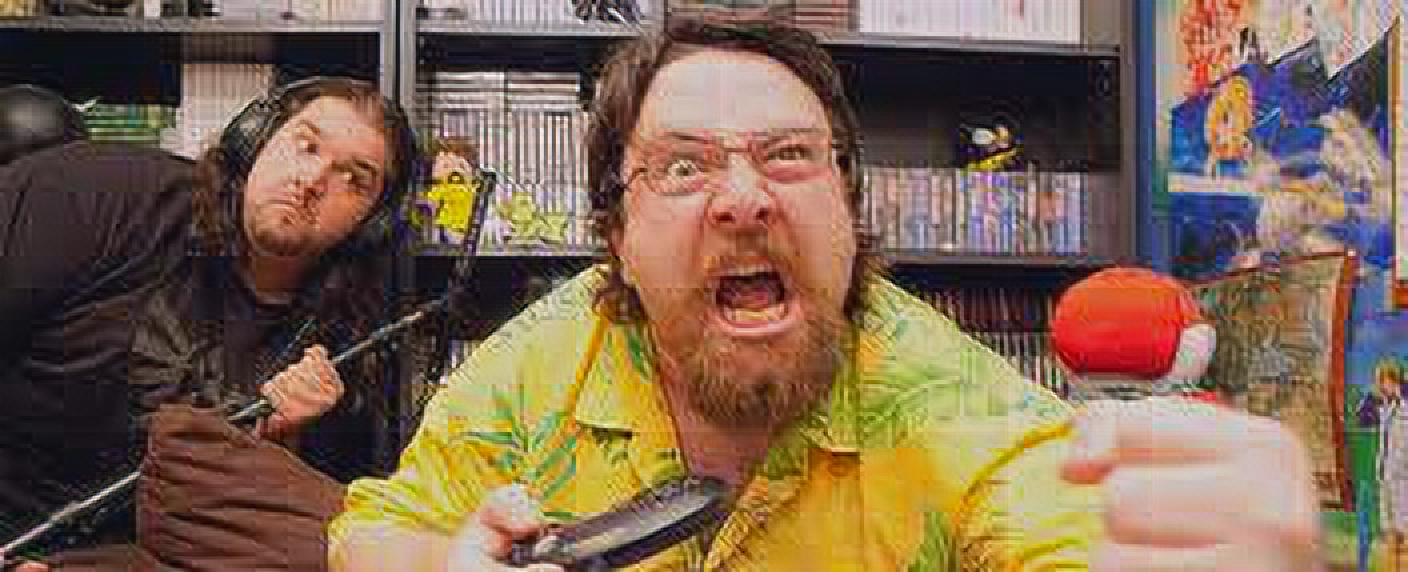

In [6]:
sr_img = rrdn.predict(lr_img, by_patch_of_size=36)

Image.fromarray(sr_img)
